In [12]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    gpu_id = torch.cuda.current_device()  # 获取当前 GPU ID
    gpu_name = torch.cuda.get_device_name(gpu_id)  # 获取 GPU 名称
    gpu_properties = torch.cuda.get_device_properties(gpu_id)  # 获取 GPU 详细信息
    total_memory = gpu_properties.total_memory / (1024 ** 3)  # 转换为 GB

    print(f"Using GPU: {gpu_name}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 4090
Total Memory: 23.64 GB


In [14]:
x = torch.linspace(-1, 1, 65)
y = torch.linspace(-1, 1, 65)
X, Y = torch.meshgrid(x, y, indexing='ij')  # X, Y形状均为(65, 65)
R = torch.sqrt(X**2 + Y**2)
Theta = torch.atan2(Y, X)
r_boundary = 0.6 * (1 + 0.25 * torch.sin(6 * Theta))
mask = R <= 0.98 * r_boundary

def filter_tensor(input_tensor, mask):
    m = input_tensor.shape[0]
    mask_flat = mask.reshape(-1)  # (65*65,)
    input_flat = input_tensor.reshape(m, -1)  # (m, 65*65)
    output = input_flat[:, mask_flat]  # (m, n)
    return output

def normalize_tensors(f_tensor, u_tensor):
    max_vals = u_tensor.abs().amax(dim=(1,2), keepdim=True)  # [batch, 1, 1]
    epsilon = 1e-8
    scale_factors = 1.0 / (max_vals + epsilon) 
    
    scaled_f = f_tensor * scale_factors
    scaled_u = u_tensor * scale_factors
    
    return scaled_f, scaled_u

def filter_outliers(f_tensor, u_tensor, threshold=5.5):
    f_mean = f_tensor.mean(dim=(1,2), keepdim=True)
    f_std = f_tensor.std(dim=(1,2), keepdim=True) + 1e-8  # 避免除零
    u_mean = u_tensor.mean(dim=(1,2), keepdim=True)
    u_std = u_tensor.std(dim=(1,2), keepdim=True) + 1e-8  # 避免除零

    f_zscore = (f_tensor - f_mean) / f_std
    u_zscore = (u_tensor - u_mean) / u_std

    valid_mask = (f_zscore.abs().amax(dim=(1,2)) < threshold) & (u_zscore.abs().amax(dim=(1,2)) < threshold)
    
    f_tensor_cleaned = f_tensor[valid_mask]
    u_tensor_cleaned = u_tensor[valid_mask]
    
    return f_tensor_cleaned, u_tensor_cleaned


def getTensor(data_dir, tau):
    all_files = sorted(os.listdir(data_dir), key=lambda x: int(re.search(r'\d+', x).group()))

    f_paths = [os.path.join(data_dir, f) for f in all_files if f.startswith('f_')]
    u_paths = [os.path.join(data_dir, f) for f in all_files if f.startswith('u_')]

    raw_f_list = []
    raw_u_list = []
    for f_path, u_path in zip(f_paths, u_paths):
        raw_f_list.append(np.loadtxt(f_path) * tau)     # generating Data with eq 1/tau u - laplace u = f. But in this code we consider u - tau * laplace u = f
        raw_u_list.append(np.loadtxt(u_path))

    print(len(raw_f_list), len(raw_u_list))

    f_list = []
    u_list = []

    for f_mat, u_mat in zip(raw_f_list, raw_u_list):
        f_max = np.max(np.abs(f_mat))
        u_max = np.max(np.abs(u_mat))
        
        if f_max > 1e-3 and u_max > 1e-3 and f_max < 2 and u_max < 2:
            f_list.append(f_mat)  
            u_list.append(u_mat)

    print(len(f_list), len(u_list))

    raw_f_tensor = torch.FloatTensor(np.array(f_list))
    raw_u_tensor = torch.FloatTensor(np.array(u_list))
    print(raw_f_tensor.shape, raw_u_tensor.shape)

    f_tensor_, u_tensor_ = filter_outliers(raw_f_tensor, raw_u_tensor)
    # f_tensor, u_tensor = normalize_tensors(raw_f_tensor, raw_u_tensor)
    print(f_tensor_.shape, u_tensor_.shape)

    f_tensor = filter_tensor(f_tensor_, mask)
    u_tensor = filter_tensor(u_tensor_, mask)
    tau_tensor = tau + torch.zeros(f_tensor.shape[0]).view(-1, 1)
    f_tensor = f_tensor / tau
    u_tensor = u_tensor / tau
    print(f_tensor.shape, u_tensor.shape, tau_tensor.shape)

    return f_tensor_, u_tensor_, f_tensor, u_tensor, tau_tensor

In [15]:
raw_f_tensor_list = []
raw_u_tensor_list = []
f_tensor_list = []
u_tensor_list = []
tau_tensor_list = []

for i in range(11):
    dir = "../GeneratingData/build/result/Data" + str(i + 1)
    tau = 0.05 + 0.005 * i
    print("Reading Data for tau = ", tau)

    a, b, c, d, e = getTensor(dir, tau)

    raw_f_tensor_list.append(a)
    raw_u_tensor_list.append(b)
    f_tensor_list.append(c)
    u_tensor_list.append(d)
    tau_tensor_list.append(e)

    print("=======================================================================")

Reading Data for tau =  0.05
3364 3364
2711 2711
torch.Size([2711, 65, 65]) torch.Size([2711, 65, 65])
torch.Size([2059, 65, 65]) torch.Size([2059, 65, 65])
torch.Size([2059, 1151]) torch.Size([2059, 1151]) torch.Size([2059, 1])
Reading Data for tau =  0.055
3364 3364
2723 2723
torch.Size([2723, 65, 65]) torch.Size([2723, 65, 65])
torch.Size([2059, 65, 65]) torch.Size([2059, 65, 65])
torch.Size([2059, 1151]) torch.Size([2059, 1151]) torch.Size([2059, 1])
Reading Data for tau =  0.060000000000000005
3364 3364
2731 2731
torch.Size([2731, 65, 65]) torch.Size([2731, 65, 65])
torch.Size([2059, 65, 65]) torch.Size([2059, 65, 65])
torch.Size([2059, 1151]) torch.Size([2059, 1151]) torch.Size([2059, 1])
Reading Data for tau =  0.065
3364 3364
2731 2731
torch.Size([2731, 65, 65]) torch.Size([2731, 65, 65])
torch.Size([2059, 65, 65]) torch.Size([2059, 65, 65])
torch.Size([2059, 1151]) torch.Size([2059, 1151]) torch.Size([2059, 1])
Reading Data for tau =  0.07
3364 3364
2731 2731
torch.Size([2731,

In [16]:
f_tensor_ = torch.cat(raw_f_tensor_list, dim=0)
u_tensor_ = torch.cat(raw_u_tensor_list, dim=0)
f_tensor = torch.cat(f_tensor_list, dim=0)
tau_tensor = torch.cat(tau_tensor_list, dim=0)
u_tensor = torch.cat(u_tensor_list, dim=0)

f_tensor_.shape, u_tensor_.shape, f_tensor.shape, tau_tensor.shape, u_tensor.shape 

(torch.Size([22649, 65, 65]),
 torch.Size([22649, 65, 65]),
 torch.Size([22649, 1151]),
 torch.Size([22649, 1]),
 torch.Size([22649, 1151]))

In [17]:
class LinearNet(nn.Module):
    def __init__(self, NL, NN, input, output):     ## NL是有多少层隐藏层, NN是每层的神经元数量
        super(LinearNet, self).__init__()
        self.input_layer = nn.Linear(input, NN, bias=True)
        self.hidden_layer = nn.ModuleList([nn.Linear(NN, NN, bias=True) for i in range(NL)])
        self.output_layer = nn.Linear(NN, output, bias=True)

    def forward(self, x):
        o = self.act(self.input_layer(x))
        for i, li in enumerate(self.hidden_layer):  
            o = self.act(li(o))
        out = self.output_layer(o)
        return out

    def act(self, x):
        # return torch.tanh(x)
        return x  
    
class DeepOnet(nn.Module):
    def __init__(self, NL, NN, input, output, temp):     ## NL是有多少层隐藏层, NN是每层的神经元数量
        super(DeepOnet, self).__init__()
        self.f_layer = LinearNet(NL, NN, input, temp)
        self.tau_layer = torch.nn.Sequential(torch.nn.Linear(1, NN), nn.Tanh(), torch.nn.Linear(NN, NN), nn.Tanh(), torch.nn.Linear(NN, NN), nn.Tanh(), torch.nn.Linear(NN, temp))
        self.out_layer = LinearNet(NL, NN, temp, output)

    def forward(self, f, tau):
        # return self.out_layer(self.f_layer(f) * self.tau_layer(1 / tau))
        return self.out_layer(self.f_layer(f) * self.tau_layer(torch.sqrt(tau)))

In [18]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(f_tensor, tau_tensor, u_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_f = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))]).to(device)
train_tau = torch.stack([train_dataset[i][1] for i in range(len(train_dataset))]).to(device)
train_u = torch.stack([train_dataset[i][2] for i in range(len(train_dataset))]).to(device)

test_f = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))]).to(device)
test_tau = torch.stack([test_dataset[i][1] for i in range(len(test_dataset))]).to(device)
test_u = torch.stack([test_dataset[i][2] for i in range(len(test_dataset))]).to(device)

In [19]:
def check_data_stats(name, data):
    print(f"{name} - Mean: {data.mean().item():.4f}, Std: {data.std().item():.4f}, Max: {data.max().item():.4f}, Min: {data.min().item():.4f}")

check_data_stats("train_f", train_f)
check_data_stats("train_tau", train_tau)
check_data_stats("train_u", train_u)
check_data_stats("test_f", test_f)
check_data_stats("test_tau", test_tau)
check_data_stats("test_u", test_u)

train_f - Mean: 0.5072, Std: 0.6551, Max: 4.4651, Min: -2.0651
train_tau - Mean: 0.0749, Std: 0.0158, Max: 0.1000, Min: 0.0500
train_u - Mean: 0.1258, Std: 0.1804, Max: 0.8676, Min: -0.2619
test_f - Mean: 0.5104, Std: 0.6541, Max: 4.4651, Min: -2.0651
test_tau - Mean: 0.0753, Std: 0.0158, Max: 0.1000, Min: 0.0500
test_u - Mean: 0.1269, Std: 0.1807, Max: 0.8676, Min: -0.2619


In [20]:
# train_dataset = TensorDataset(train_f, train_tau, train_u)
# test_dataset = TensorDataset(test_f, test_tau, test_u)

# batch_size = 8096

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
n = f_tensor.shape[1]

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time

net = DeepOnet(NL = 2, NN = n, input = n, output = n, temp = 2 * n).to(device)

criterion = nn.MSELoss() 
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1000, factor=0.7)

best_test_loss = float('inf')  
no_improve_counter = 0
early_stop_patience = 10000      
num_epochs = 50000
record_training_loss = np.zeros((num_epochs))
record_test_loss = np.zeros((num_epochs))

start = time.time()

for epoch in range(num_epochs):
    net.train()  

    optimizer.zero_grad()

    outputs = net(train_f, train_tau)
    loss = criterion(outputs, train_u)
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
    optimizer.step()

    epoch_loss = loss.item()

    record_training_loss[epoch] = epoch_loss

    net.eval()  
    # test_loss = 0.0
    with torch.no_grad():
        outputs = net(test_f, test_tau)
        test_loss = criterion(outputs, test_u).item()
    
    record_test_loss[epoch] = test_loss
    
    # net.train()  
    # running_loss = 0.0
    # for batch_f, batch_tau, batch_u in train_loader:
    #     batch_f, batch_tau, batch_u = batch_f.to(device), batch_tau.to(device), batch_u.to(device)
    #     optimizer.zero_grad()
        
    #     outputs = net(batch_f, batch_tau)
        
    #     loss = criterion(outputs, batch_u)
        
    #     loss.backward()
    #     torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
    #     optimizer.step()
        
    #     running_loss += loss.item()
    
    # epoch_loss = running_loss / len(train_loader)
    # record_training_loss[epoch] = running_loss

    # net.eval()  
    # test_loss = 0.0
    # with torch.no_grad():
    #     for batch_f, batch_tau, batch_u in test_loader:
    #         batch_f, batch_tau, batch_u = batch_f.to(device), batch_tau.to(device), batch_u.to(device)
    #         outputs = net(batch_f, batch_tau)
    #         test_loss += criterion(outputs, batch_u).item()
    
    # test_loss /= len(test_loader)
    # record_test_loss[epoch] = test_loss
    
    if (epoch+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {epoch_loss:.8f} Testing Loss: {test_loss:.8f} lr: {scheduler.get_last_lr()}")

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        no_improve_counter = 0 
        torch.save(net.state_dict(), 'net.pth')
    else:
        no_improve_counter += 1
        if no_improve_counter >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

    scheduler.step(test_loss)  

print("Training finished!")
end = time.time()
print("Time of training process by", device, ": ", end - start, "s")

Epoch [50/50000] Training Loss: 0.01475931 Testing Loss: 0.08454867 lr: [0.001]
Epoch [100/50000] Training Loss: 0.14655118 Testing Loss: 0.07131019 lr: [0.001]
Epoch [150/50000] Training Loss: 0.00636718 Testing Loss: 0.01220267 lr: [0.001]
Epoch [200/50000] Training Loss: 0.00135077 Testing Loss: 0.00119652 lr: [0.001]
Epoch [250/50000] Training Loss: 0.00098865 Testing Loss: 0.00101024 lr: [0.001]
Epoch [300/50000] Training Loss: 0.00069436 Testing Loss: 0.00068665 lr: [0.001]
Epoch [350/50000] Training Loss: 3.84957051 Testing Loss: 7.33643007 lr: [0.001]
Epoch [400/50000] Training Loss: 0.86743224 Testing Loss: 6.32651711 lr: [0.001]
Epoch [450/50000] Training Loss: 1.34084773 Testing Loss: 0.44749784 lr: [0.001]
Epoch [500/50000] Training Loss: 0.04636702 Testing Loss: 0.04575514 lr: [0.001]
Epoch [550/50000] Training Loss: 0.01488562 Testing Loss: 0.02751820 lr: [0.001]
Epoch [600/50000] Training Loss: 0.00856527 Testing Loss: 0.01750529 lr: [0.001]
Epoch [650/50000] Training Lo

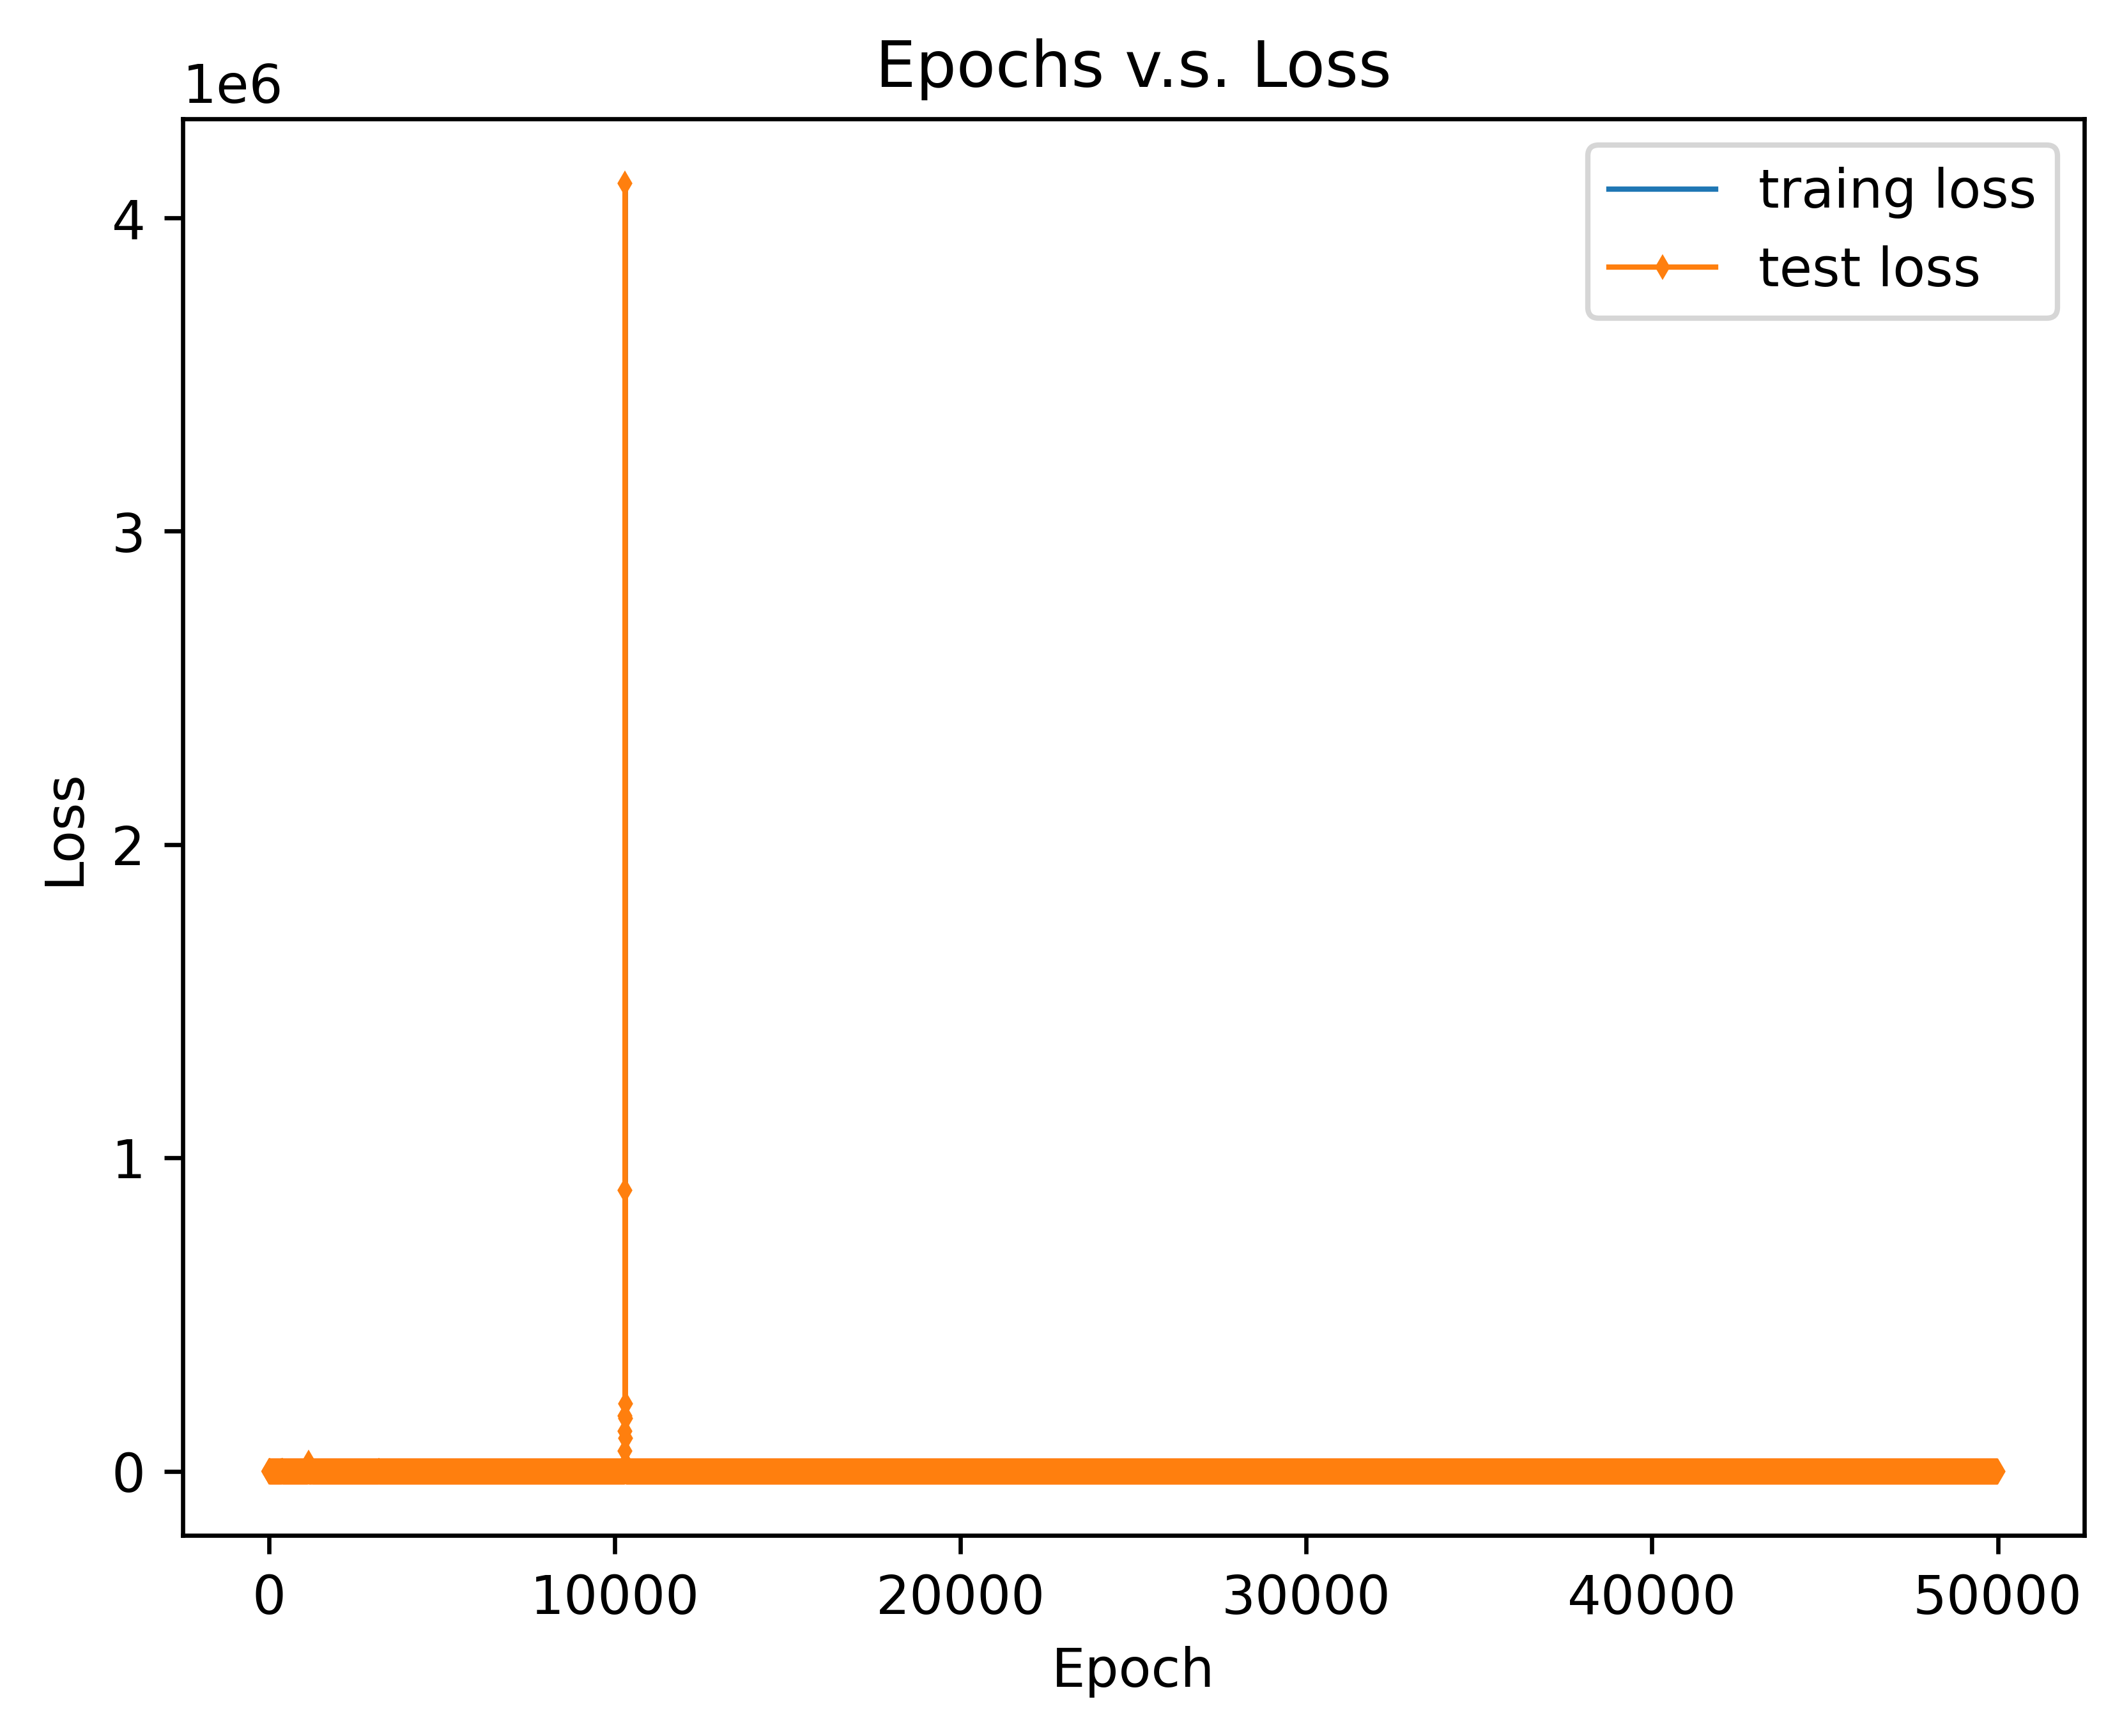

In [23]:
epochs = np.arange(1, len(record_training_loss) + 1)

fig = plt.figure(dpi = 600, facecolor='white')
plt.plot(epochs, record_training_loss, label='traing loss', markersize = 2, linewidth = 1)
plt.plot(epochs, record_test_loss, label='test loss', marker='d', markersize = 2, linewidth = 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs v.s. Loss')

plt.legend()
plt.show()

In [24]:
net = DeepOnet(NL = 2, NN = n, input = n, output = n, temp = n * 2).to(device)
net.load_state_dict(torch.load('net.pth', map_location = device, weights_only=True))

<All keys matched successfully>

In [25]:
import math

def inverse_filter_tensor(compressed_tensor, mask, fill_value=0):
    m = compressed_tensor.shape[0]
    total_points = 65 * 65
    
    output_flat = torch.full((m, total_points), fill_value, dtype=compressed_tensor.dtype).to(device)
    
    mask_flat = mask.reshape(-1)
    active_indices = torch.where(mask_flat)[0]  
    
    output_flat[:, active_indices] = compressed_tensor
    
    output = output_flat.reshape(m, 65, 65)
    return output

def calculate_errors(predictions, selected_labels):
    batch_size, n, m = predictions.shape
    n_features = n * m 
    sqrt_n = math.sqrt(n_features)  
    
    predictions_flat = predictions.view(batch_size, -1)
    labels_flat = selected_labels.view(batch_size, -1)
    
    absolute_diff = predictions_flat - labels_flat
    absolute_l2 = torch.norm(absolute_diff, p=2, dim=1) / sqrt_n  
    absolute_linf = torch.norm(absolute_diff, p=float('inf'), dim=1)
    
    epsilon = 1e-8
    label_l2 = torch.norm(labels_flat, p=2, dim=1) / sqrt_n + epsilon
    relative_l2 = absolute_l2 / label_l2
    
    label_linf = torch.norm(labels_flat, p=float('inf'), dim=1) + epsilon
    relative_linf = absolute_linf / label_linf
    
    print("="*50)
    print(f"Error Analysis Report (Samples: {batch_size}, Features: {n}x{m}={n_features})")
    print("="*50)
    
    for i in range(batch_size):
        print(f"\nSample {i} Results:")
        print(f"  Absolute L2 Error: {absolute_l2[i].item():.8f}")
        print(f"  Relative L2 Error: {relative_l2[i].item():.8f}")  
        print(f"  Absolute Linf Error: {absolute_linf[i].item():.8f}")
        print(f"  Relative Linf Error: {relative_linf[i].item():.8f}")
    print("\n" + "="*50 + "\n")


def calculate_random_sample_errors(model, test_inputs_u, test_inputs_tau, test_labels, num_samples=10):
    model.eval()
    with torch.no_grad():
        
        total_samples = test_inputs_u.size(0)
        sample_indices = torch.randperm(total_samples)[:num_samples]

        print(sample_indices)
        
        selected_inputs_u = test_inputs_u[sample_indices]
        selected_inputs_u = filter_tensor(selected_inputs_u, mask)
        selected_inputs_tau = test_inputs_tau[sample_indices]
        predictions = model(selected_inputs_u.to(device), selected_inputs_tau.to(device))
        predictions = inverse_filter_tensor(predictions, mask)

        selected_labels = test_labels[sample_indices].to(device)

        print("tau = ", selected_inputs_tau)
        
        calculate_errors(predictions, selected_labels)

In [26]:
calculate_random_sample_errors(net, f_tensor_, tau_tensor, u_tensor_)

tensor([15325, 21493, 16726,  1459, 13680,  5232, 14453, 16875, 12909, 22024])
tau =  tensor([[0.0850],
        [0.1000],
        [0.0900],
        [0.0500],
        [0.0800],
        [0.0600],
        [0.0850],
        [0.0900],
        [0.0800],
        [0.1000]])
Error Analysis Report (Samples: 10, Features: 65x65=4225)

Sample 0 Results:
  Absolute L2 Error: 0.00001772
  Relative L2 Error: 0.02069858
  Absolute Linf Error: 0.00032982
  Relative Linf Error: 0.10068426

Sample 1 Results:
  Absolute L2 Error: 0.00004838
  Relative L2 Error: 0.01709589
  Absolute Linf Error: 0.00116464
  Relative Linf Error: 0.10479321

Sample 2 Results:
  Absolute L2 Error: 0.00005354
  Relative L2 Error: 0.01565232
  Absolute Linf Error: 0.00125727
  Relative Linf Error: 0.10569343

Sample 3 Results:
  Absolute L2 Error: 0.00010585
  Relative L2 Error: 0.00980715
  Absolute Linf Error: 0.00384409
  Relative Linf Error: 0.10121388

Sample 4 Results:
  Absolute L2 Error: 0.00002699
  Relative L2 Error: